# Random Forests (RF) Implementation

#### In this Jupyter notebook, I implement a **Random Forest Regressor** to predict housing prices.

#### Random forests are an ensemble learning method that builds multiple regression trees and combines their outputs to make more accurate predictions. Each tree is trained on a bootstrapped sample (random sample with replacement) of the data, and at each split, only a random subset of features is considered, to reduce overfitting. 

#### The goal of this notebook is to predict the selling price of a house based on its features — such as square footage, number of bedrooms and bathrooms, lot size, and zip code — and to compare the performance of a random forest model to that of a single regression tree. I will also explore feature importance to understand which variables most strongly influence the model’s predictions.

In [8]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.utils import resample

## Import & Filter the Data
The same cell is in RT because these two use the same data

In [2]:
df = pd.read_csv("test.csv")  

# Convert acres to square feet if needed for the 'lot_size' feature
def convert_lot_size(row):
    if row['lot_size_units'] == 'acre':
        return row['lot_size'] * 43560  # 1 acre = 43,560 sq ft
    return row['lot_size']

df['lot_size_sqft'] = df.apply(convert_lot_size, axis=1)

# Drop rows with missing values in essential features
df_clean = df.dropna(subset=['beds', 'baths', 'size', 'lot_size_sqft', 'zip_code', 'price'])

# Define features and target
X = df_clean[['beds', 'baths', 'size', 'lot_size_sqft', 'zip_code']]
y = np.log(df_clean['price'])  # log transform target for stability

# Train/test split of 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## RF Algorithm

In [5]:
# This is all the same as from RT.ipynb, but jupyter notebooks don't allow importing classes between each other.
class RegressionTreeNode:
    def __init__(self, depth=0, max_depth=None):
        self.depth = depth
        self.max_depth = max_depth
        self.left = None
        self.right = None
        self.feature_index = None
        self.threshold = None
        self.value = None  # For leaf nodes

    def fit(self, X, y):
        if len(set(y)) == 1 or (self.max_depth is not None and self.depth >= self.max_depth):
            self.value = np.mean(y)
            return

        best_mse = float('inf')
        best_feature = None
        best_threshold = None

        for feature_index in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_mask = X[:, feature_index] <= threshold
                right_mask = ~left_mask

                y_left = y[left_mask]
                y_right = y[right_mask]

                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                current_mse = (
                    len(y_left) * np.var(y_left) + len(y_right) * np.var(y_right)
                ) / len(y)

                if current_mse < best_mse:
                    best_mse = current_mse
                    best_feature = feature_index
                    best_threshold = threshold

        if best_feature is None:
            self.value = np.mean(y)
            return

        self.feature_index = best_feature
        self.threshold = best_threshold

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        self.left = RegressionTreeNode(depth=self.depth + 1, max_depth=self.max_depth)
        self.right = RegressionTreeNode(depth=self.depth + 1, max_depth=self.max_depth)

        self.left.fit(X[left_mask], y[left_mask])
        self.right.fit(X[right_mask], y[right_mask])

    def predict_one(self, x):
        if self.value is not None:
            return self.value
        if x[self.feature_index] <= self.threshold:
            return self.left.predict_one(x)
        else:
            return self.right.predict_one(x)

    def predict(self, X):
        return np.array([self.predict_one(x) for x in X])

### Random Forest Regressor Implementation

To improve on the performance of a single regression tree, I implemented a **Random Forest Regressor**. A random forest is an ensemble method that builds multiple decision trees and combines their predictions. This implementation uses the `RegressionTreeNode` class from the previous folder's jupyter notebook, RT.ipynb, which is copy-pasted above. This `RandomForestRegressorScratch` class trains `n_estimators`, which are separate trees, and the RF algorithm predicts by averaging all those trees' predictions. 

In [10]:
class RandomForestRegressorScratch:
    def __init__(self, n_estimators=10, max_depth=5):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_estimators):
            # Bootstrap sample
            X_sample, y_sample = resample(X, y, replace=True)
            tree = RegressionTreeNode(max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        # Collect predictions from each tree
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        # Average predictions
        return np.mean(tree_preds, axis=0)


### Train and Evaluate

We now train `RandomForestRegressorScratch` on the housing dataset using 20 trees, each limited to a `max_depth` of 7. 

Each tree is trained on a **bootstrapped sample** (random sampling with replacement) of the training data. This reduces variance in the model because, whereas one tree can be quite sensitive to changes in the training data, the average of many trees, each with its own training data, is less unstable. 

After training, we transform the log predictions back to the original price scale and evaluate the model's performance using the mean squared error and R² score 

In [14]:
# Use log(price) for y
rf_scratch = RandomForestRegressorScratch(n_estimators=20, max_depth=7)
rf_scratch.fit(X_train.values, y_train.values)

# Predict and transform back to price scale
y_pred_log_rf = rf_scratch.predict(X_test.values)
y_pred_rf = np.exp(y_pred_log_rf)

print("Random Forest")
print("MSE:", mean_squared_error(np.exp(y_test), y_pred_rf))
print("R²:", r2_score(np.exp(y_test), y_pred_rf))

Random Forest
MSE: 70739027573.67899
R²: 0.7868564530802201


The mean squared error (MSE) is approximately 70.7 billion, which indicates the average squared difference between predicted and actual housing prices has dropped substantially, though it is still high (for context, the square root of 70.7 billion is roughly 266,000). This is a significant improvement over the previous model (Regression Tree), where MSEs were over 180 billion.

The R² score is 0.787, meaning the random forest model explains nearly 79% of the variance in housing prices. Compared to the single regression tree, which explained only around 53% at best, this ensemble method reduces variance and generalizes better on real-world data with noise and nonlinear interactions.

## Result

### Results: Tuning the Number of Trees

Seeing as how the random forests algorithm netted a much better R² score than the single regression three before finetuning its parameter(s), I want to evaluate  how the number of trees affects the model’s performance. Thus, I trained random forests with increasing numbers of estimators (trees) to find out what is the best number of trees to have in a forest.

In [ ]:
n_trees_list = [1, 5, 10, 20, 50, 100]
r2_scores = []
mse_scores = []

for n in n_trees_list:
    rf = RandomForestRegressorScratch(n_estimators=n, max_depth=7)
    rf.fit(X_train.values, y_train.values)
    y_pred_log = rf.predict(X_test.values)
    y_pred = np.exp(y_pred_log)
    
    r2 = r2_score(np.exp(y_test), y_pred)
    mse = mean_squared_error(np.exp(y_test), y_pred)

    r2_scores.append(r2)
    mse_scores.append(mse)
    print(f"{n} trees → R²: {r2:.4f}, MSE: {mse:.2f}")


1 trees → R²: 0.2914, MSE: 235178766233.77
5 trees → R²: 0.6022, MSE: 132027413555.99
10 trees → R²: 0.6363, MSE: 120721551601.15
20 trees → R²: 0.6774, MSE: 107054824180.03
50 trees → R²: 0.7149, MSE: 94633190178.78


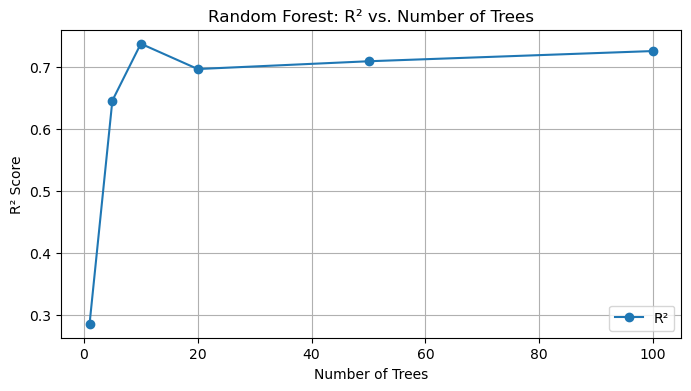

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(n_trees_list, r2_scores, marker='o', label="R²")
plt.xlabel("Number of Trees")
plt.ylabel("R² Score")
plt.title("Random Forest: R² vs. Number of Trees")
plt.grid(True)
plt.legend()
plt.show()



As expected, the R² score improves rapidly at first, then gradually levels off as more trees are added.


This behavior illustrates a key trait of ensemble methods: **adding more models improves stability**, but beyond a certain point, the returns diminish. For this dataset, around **20–50 trees** appears to be a sweet spot, beyond which performance gains are minor.

By avoiding excessively large ensembles, we reduce training time while still maintaining strong predictive power.

## Analysis & Discussion

import matplotlib.pyplot as plt
import seaborn as sns

# Ensure predictions are already made
# y_test_exp = np.exp(y_test)
y_test_exp = np.exp(y_test)  # just to be explicit

# For comparison: predictions from each model
# y_pred_tree and y_pred_rf should already be defined

plt.figure(figsize=(12, 5))

# Regression Tree (single)
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_exp, y=y_pred_tree)
plt.plot([y_test_exp.min(), y_test_exp.max()], [y_test_exp.min(), y_test_exp.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Regression Tree Predictions")
plt.grid(True)

# Random Forest
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_exp, y=y_pred_rf)
plt.plot([y_test_exp.min(), y_test_exp.max()], [y_test_exp.min(), y_test_exp.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Random Forest Predictions")
plt.grid(True)

plt.tight_layout()
plt.show()
